# MVP Report

## Zillow: What is driving the errors in the Zestimates®?

### Overview of Data Science Pipeline Within This Notebook

### Goals
- To improve our original estimate of the log error by using clustering methodologies.
- To find the key drivers of error in the Zestimate® figures.

### 1. Acquire
- Data is aquired from the Zillow SQL Database.
- Login credentials are required.
- The functions are stored in the acquire.py file.
- File is a reproducible component for gathering the data.  

### 2. Prepare
- Created a prepare.py file.
- Data is split into train, validate, and test.
- Data is scaled as necessary.
- Make sure that column data types are appropriate for the data they contain.
- Missing values are investigated and handled.
- Outliers are investigated and handled.
- File is a reproducible component that handles missing values, outliers, and changes in data types.  

### 3. Explore
- Run statistical testing and visualization.
- At least 3 combinations of features for clustering should be tried.
- Summarized your takeaways and conclusions.

### 4. Modeling
- At least 4 different models are created and their performance is compared.
- One model is the distinct combination of algorithm, hyperparameters, and features.

### 5. Conclusions
- Observations:
- Takeaways:

# Imports 

In [1]:
# Set up the notebook imports
# Import Modules
import acquire
import prepare

# Basic Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Modeling Imports
from sklearn.cluster import KMeans, dbscan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

# Modeling Metrics
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('Imports Completed.')

Imports Completed.


## 1. Acquire

In [2]:
# 260: residential general
# 261: single family residential
# 263: mobile home
# 264: townhouse
# 266: condominium 
# 279: inferred single family residential

In [3]:
df = acquire.zillow_data()

In [4]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,parcelid,logerror,transactiondate
0,1,10759547,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,...,2015.0,27516.0,NaN,None,NaN,NaN,1,17052889,0.055619,2017-01-01
1,6,10933547,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,...,2016.0,159016.0,6773.34,None,NaN,NaN,6,12095076,-0.001011,2017-01-01
2,14,11142747,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,...,2015.0,4265.0,NaN,None,NaN,NaN,14,14731691,-0.008935,2017-01-02
3,15,11193347,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,...,2016.0,10.0,NaN,None,NaN,NaN,15,17110996,0.008669,2017-01-02
4,16,11215747,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,...,2016.0,10.0,NaN,None,NaN,NaN,16,14375300,-0.021896,2017-01-02


In [5]:
df.shape

(70364, 63)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70364 entries, 0 to 70363
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            70364 non-null  int64  
 1   parcelid                      70364 non-null  int64  
 2   airconditioningtypeid         19706 non-null  float64
 3   architecturalstyletypeid      151 non-null    float64
 4   basementsqft                  44 non-null     float64
 5   bathroomcnt                   70364 non-null  float64
 6   bedroomcnt                    70364 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         44451 non-null  float64
 9   calculatedbathnbr             68177 non-null  float64
 10  decktypeid                    487 non-null    float64
 11  finishedfloor1squarefeet      5669 non-null   float64
 12  calculatedfinishedsquarefeet  69345 non-null  float64
 13  f

In [7]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id,parcelid,logerror
count,70364.000000,7.036400e+04,19706.000000,151.000000,44.000000,70364.000000,70364.000000,44451.000000,68177.000000,487.0,...,6.921600e+04,6.944300e+04,70364.000000,6.875700e+04,6.992500e+04,1321.000000,6.877400e+04,70364.000000,7.036400e+04,70364.000000
mean,38948.813740,1.345496e+07,1.958033,7.430464,591.818182,2.176887,3.025041,6.395177,2.245882,66.0,...,1.767063e+05,4.397330e+05,2015.998408,2.662343e+05,5.325672e+03,13.922029,6.049483e+13,38948.813740,1.300694e+07,0.016817
std,22408.699531,8.563498e+06,3.189763,2.629347,466.160182,1.015034,1.110356,1.700978,0.952441,0.0,...,3.955017e+05,8.428115e+05,0.049416,5.409097e+05,1.055420e+04,1.557234,2.110535e+11,22408.699531,3.509369e+06,0.171052
min,1.000000,1.071174e+07,1.000000,2.000000,63.000000,0.000000,0.000000,1.000000,1.000000,66.0,...,5.000000e+00,9.000000e+00,2014.000000,4.000000e+00,2.540000e+00,6.000000,6.037101e+13,1.000000,1.071186e+07,-4.655420
25%,19396.750000,1.157973e+07,1.000000,7.000000,219.000000,2.000000,2.000000,5.000000,2.000000,66.0,...,7.766700e+04,1.853655e+05,2016.000000,7.720100e+04,2.412050e+03,14.000000,6.037312e+13,19396.750000,1.153918e+07,-0.024304
50%,39117.500000,1.261348e+07,1.000000,7.000000,528.000000,2.000000,3.000000,6.000000,2.000000,66.0,...,1.262855e+05,3.195910e+05,2016.000000,1.755060e+05,3.953200e+03,14.000000,6.037575e+13,39117.500000,1.252935e+07,0.006670
75%,58238.250000,1.416926e+07,1.000000,7.000000,744.500000,3.000000,4.000000,8.000000,3.000000,66.0,...,2.030500e+05,5.126240e+05,2016.000000,3.270000e+05,6.141260e+03,15.000000,6.059052e+13,58238.250000,1.420976e+07,0.039233
max,77613.000000,1.696019e+08,13.000000,21.000000,2443.000000,20.000000,25.000000,12.000000,20.000000,66.0,...,6.640493e+07,1.491392e+08,2016.000000,9.401108e+07,1.824155e+06,15.000000,6.111009e+13,77613.000000,1.676893e+08,5.262999


In [8]:
df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       50658
architecturalstyletypeid    70213
basementsqft                70320
                            ...  
censustractandblock          1590
id                              0
parcelid                        0
logerror                        0
transactiondate                 0
Length: 63, dtype: int64

In [9]:
null_counts = df.isnull().sum().sort_values(ascending=False)
null_counts

buildingclasstypeid     70364
finishedsquarefeet15    70357
basementsqft            70320
storytypeid             70320
yardbuildingsqft26      70299
                        ...  
roomcnt                     0
assessmentyear              0
id                          0
parcelid                    0
id                          0
Length: 63, dtype: int64

### Takeaways: 
- Too many nulls in the data
- Must clean data

## 2. Prepare  

#### Missing Values

In [10]:
# Drop any duplicates in data
df.drop_duplicates(inplace=True)

In [11]:
# Dropping id and parcelid 
cols_to_drop = ['id', 'parcelid']
df = df.drop(columns=cols_to_drop)

In [12]:
df = prepare.data_prep(
    df,
    cols_to_remove=[],
    prop_required_column=.6,
    prop_required_row=.75)

In [13]:
df.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,...,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate
1120,2.0,3.0,8.0,2.0,1766.0,1766.0,6037.0,2.0,2.0,34217790.0,...,1.0,1962.0,120205.0,390038.0,2016.0,269833.0,4915.66,6.037134e+13,0.012474,2017-01-06
1121,3.0,5.0,9.0,3.0,3085.0,3085.0,6037.0,3.0,2.0,34207325.0,...,1.0,1995.0,378688.0,947228.0,2016.0,568540.0,11815.72,6.037134e+13,0.053889,2017-01-06
1122,3.0,5.0,8.0,3.0,2401.0,2401.0,6037.0,3.0,2.0,34218324.0,...,1.0,1965.0,162046.0,237221.0,2016.0,75175.0,3063.96,6.037134e+13,-0.420413,2017-01-06
1123,3.0,4.0,7.0,3.0,2397.0,2397.0,6037.0,3.0,2.0,34212078.0,...,1.0,1984.0,274403.0,537750.0,2016.0,263347.0,6740.37,6.037134e+13,0.005598,2017-01-06
1124,3.0,4.0,7.0,3.0,2574.0,2574.0,6037.0,3.0,2.0,34217005.0,...,1.0,1981.0,239616.0,533947.0,2016.0,294331.0,6663.79,6.037134e+13,-0.094197,2017-01-06


In [14]:
df.shape

(41969, 30)

In [15]:
# Check for missing values 
df.isnull().sum()

bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
propertyzoningdesc              0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondat

In [16]:
# Drop more unnecessary columns
cols_to_drop = ['buildingqualitytypeid','calculatedbathnbr','finishedsquarefeet12','fullbathcnt', 'heatingorsystemtypeid','propertycountylandusecode',
'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'censustractandblock']
df = df.drop(columns=cols_to_drop)

In [17]:
df.shape

(41969, 15)

#### Outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a268cdc90>]],
      dtype=object)

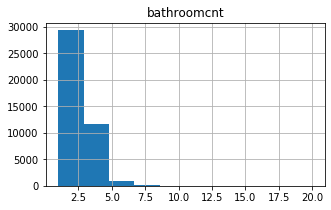

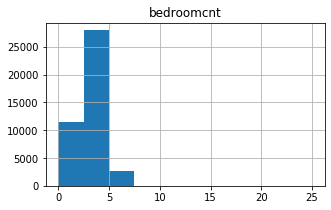

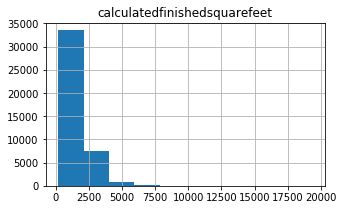

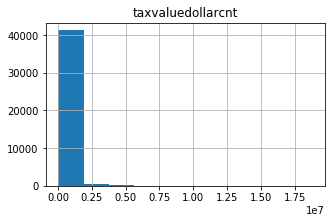

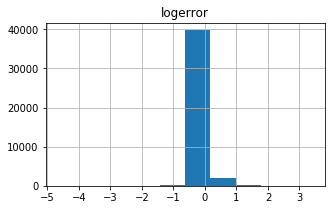

In [18]:
df.hist(column='bathroomcnt',figsize=(5, 3))
df.hist(column='bedroomcnt',figsize=(5, 3))
df.hist(column='calculatedfinishedsquarefeet',figsize=(5, 3))
df.hist(column='taxvaluedollarcnt',figsize=(5, 3))
df.hist(column='logerror',figsize=(5, 3))

In [19]:
# Use IQR to detect and remove outliers 

In [20]:
def get_upper_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = int(q3) - int(q1)
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)
    return df

add_upper_outlier_columns(df, k=1.5)

df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,...,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,assessmentyear_outliers,landtaxvaluedollarcnt_outliers,taxamount_outliers,logerror_outliers
1120,2.0,3.0,1766.0,6037.0,34217790.0,-118628236.0,9085.0,1962.0,120205.0,390038.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.00,0.000000
1121,3.0,5.0,3085.0,6037.0,34207325.0,-118662872.0,34845.0,1995.0,378688.0,947228.0,...,0.0,0,14478.5,0,23250.5,30483.0,0.0,0.0,744.37,0.014449
1122,3.0,5.0,2401.0,6037.0,34218324.0,-118637068.0,11009.0,1965.0,162046.0,237221.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.00,0.000000
1123,3.0,4.0,2397.0,6037.0,34212078.0,-118638939.0,12910.0,1984.0,274403.0,537750.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.00,0.000000
1124,3.0,4.0,2574.0,6037.0,34217005.0,-118643730.0,10095.0,1981.0,239616.0,533947.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.00,0.000000


In [21]:
outlier_cols = [col for col in df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = df[col][df[col] > 0]
    print(data.describe())

~~~
bathroomcnt_outliers
count    1042.000000
mean        1.094050
std         1.087561
min         0.500000
25%         0.500000
50%         0.500000
75%         1.500000
max        15.500000
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    30.000000
mean      1.766667
std       3.092631
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      18.000000
Name: bedroomcnt_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_outliers
count     2309.000000
mean      1082.598961
std       1314.476873
min          1.000000
25%        254.000000
50%        667.000000
75%       1384.000000
max      16163.000000
Name: calculatedfinishedsquarefeet_outliers, dtype: float64
~~~
fips_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fips_outliers, dtype: float64
~~~
latitude_outliers
count      2304.000000
mean      88901.779514
std       55899.231769
min         172.000

#### Train, Validate, Test

In [22]:
train_validate, test = train_test_split(df, test_size=.30, random_state=123)
train, validate = train_test_split(train_validate, test_size=.20, random_state=123)

print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  681558
validate observations:  170404
test observations:  365139


#### Split Data

In [23]:
# Split into X variables and y target

# X is every column except logerror
X_train = train.drop('logerror',axis=1)
# y is only log error, [[]] to keep as df and not series
y_train = train[['logerror']]

# repeat for validate and test
X_validate = validate.drop('logerror',axis=1)
y_validate = validate[['logerror']]

X_test = test.drop('logerror',axis=1)
y_test = test[['logerror']]

### Takeaways: 
- Dropped columns that were not main focus 
- Data is now cleaned and ready for exploration

## 3. Explore

#### Statistical Testing

In [24]:
# printing stats to determine baseline
print('Log Error Stats\n')
print('average:', train.logerror.mean(),'\n')
print('mode:', train.logerror.mode()[0],'\n')
print('median:', train.logerror.median(),'\n')

Log Error Stats

average: 0.01729535790425175 

mode: 0.00199263154932 

median: 0.00662132255443 



#### Visualizations

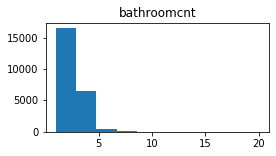

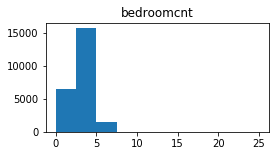

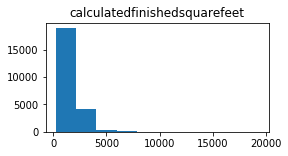

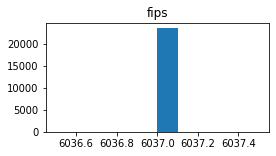

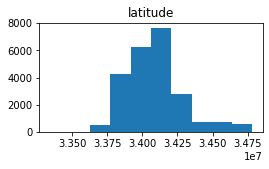

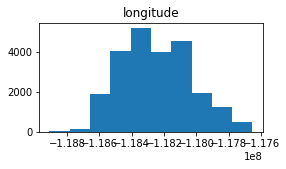

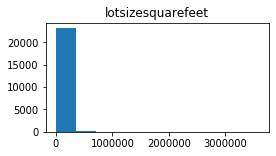

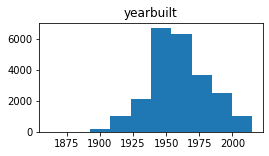

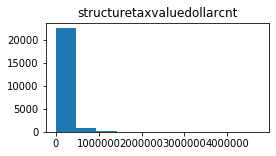

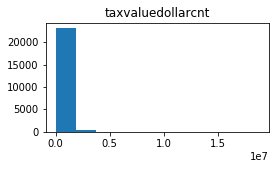

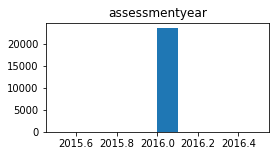

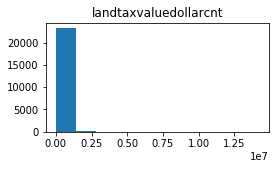

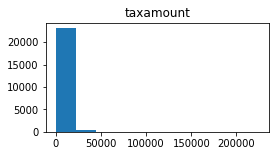

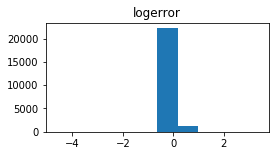

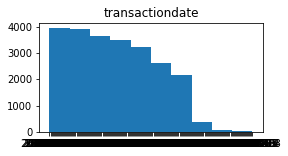

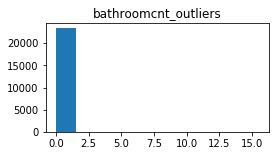

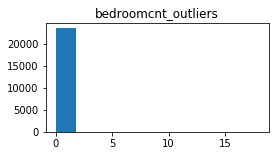

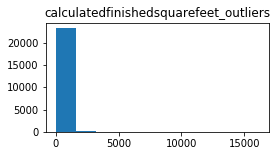

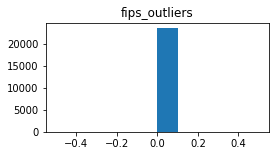

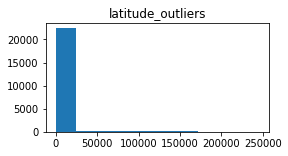

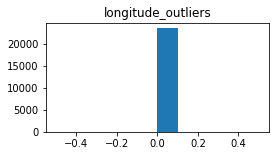

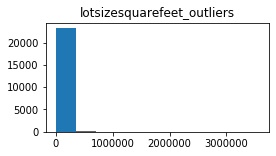

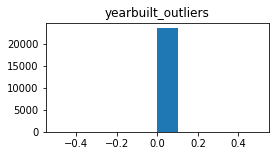

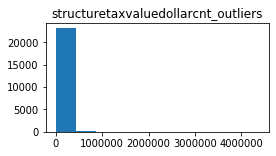

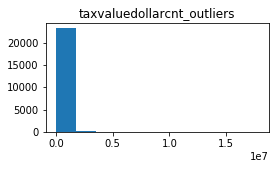

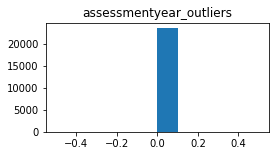

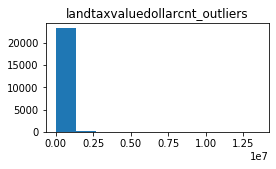

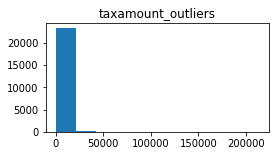

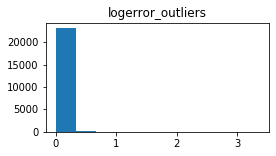

In [26]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

Is there a relationship between logerror and taxamount?


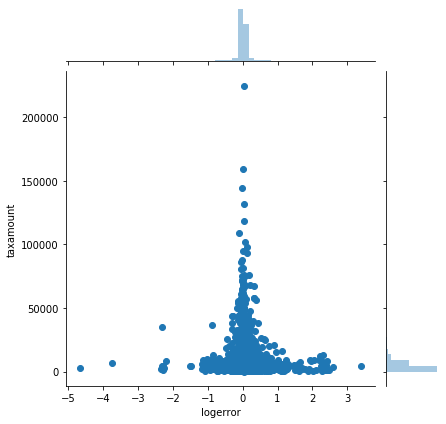

In [27]:
print("Is there a relationship between logerror and taxamount?")
sns.jointplot(y="taxamount", x="logerror", data=train)
plt.show()

- levene?

## 4. Modeling

In [29]:
X = df[['taxamount', 'logerror']]

#### Model 1

In [30]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [31]:
df['cluster'] = kmeans.predict(X)

In [32]:
kmeans.cluster_centers_

array([[4.34287151e+03, 1.70155402e-02],
       [2.73932860e+04, 1.57956234e-02]])

In [33]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,taxamount,logerror
0,4342.871514,0.017016
1,27393.285966,0.015796


In [34]:
df.groupby('cluster')['taxamount', 'logerror'].mean()

,taxamount,logerror
cluster,,
0,4343.440211,0.017016
1,27408.999871,0.015786


Text(0.5, 1.0, 'Model 1: Visualizing Cluster Centers')

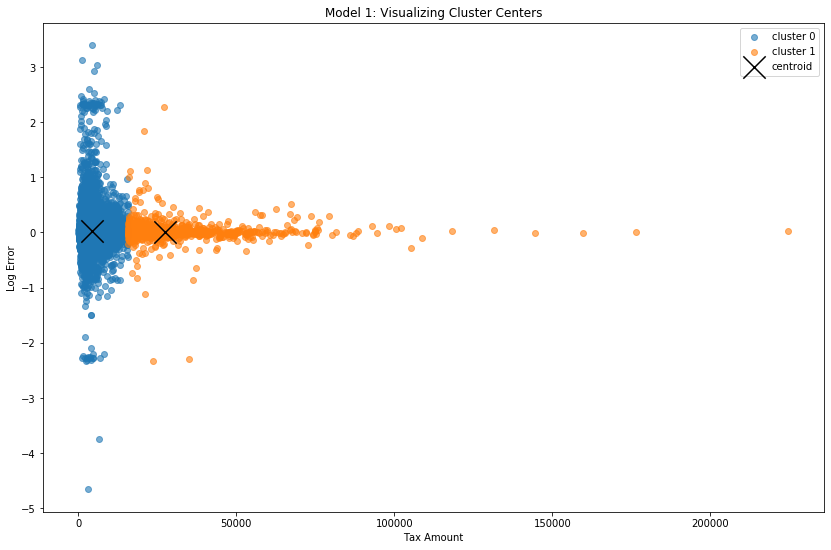

In [35]:
plt.figure(figsize=(14, 9))

for cluster, subset in df.groupby('cluster'):
    plt.scatter(subset.taxamount, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(x='taxamount', y='logerror', c='black', marker='x', s=500, ax=plt.gca(), label='centroid')

plt.legend()
plt.ylabel('Log Error')
plt.xlabel('Tax Amount')
plt.title('Model 1: Visualizing Cluster Centers')

#### Model 2

Text(0.5, 1.0, 'Model 2: Visualizing Cluster Centers')

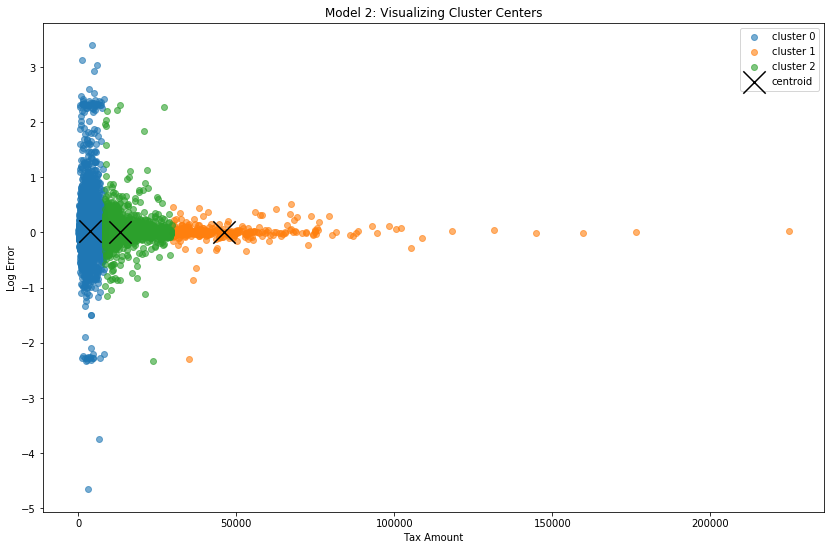

In [36]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

df['cluster'] = kmeans.predict(X)
kmeans.cluster_centers_
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
df.groupby('cluster')['taxamount', 'logerror'].mean()

plt.figure(figsize=(14, 9))

for cluster, subset in df.groupby('cluster'):
    plt.scatter(subset.taxamount, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(x='taxamount', y='logerror', c='black', marker='x', s=500, ax=plt.gca(), label='centroid')

plt.legend()
plt.ylabel('Log Error')
plt.xlabel('Tax Amount')
plt.title('Model 2: Visualizing Cluster Centers')

#### Model 3

Text(0.5, 1.0, 'Model 3: Visualizing Cluster Centers')

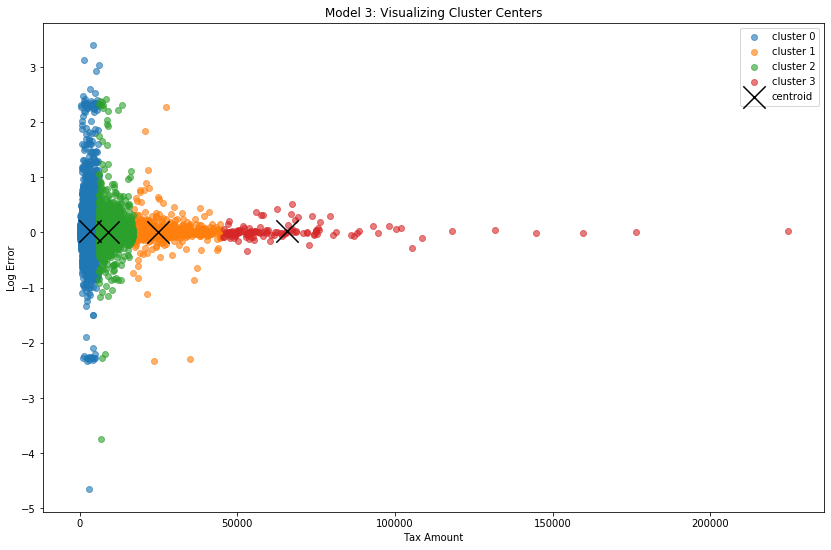

In [37]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

df['cluster'] = kmeans.predict(X)
kmeans.cluster_centers_
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
df.groupby('cluster')['taxamount', 'logerror'].mean()

plt.figure(figsize=(14, 9))

for cluster, subset in df.groupby('cluster'):
    plt.scatter(subset.taxamount, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(x='taxamount', y='logerror', c='black', marker='x', s=500, ax=plt.gca(), label='centroid')

plt.legend()
plt.ylabel('Log Error')
plt.xlabel('Tax Amount')
plt.title('Model 3: Visualizing Cluster Centers')

#### Model 4

Text(0.5, 1.0, 'Model 4: Visualizing Cluster Centers')

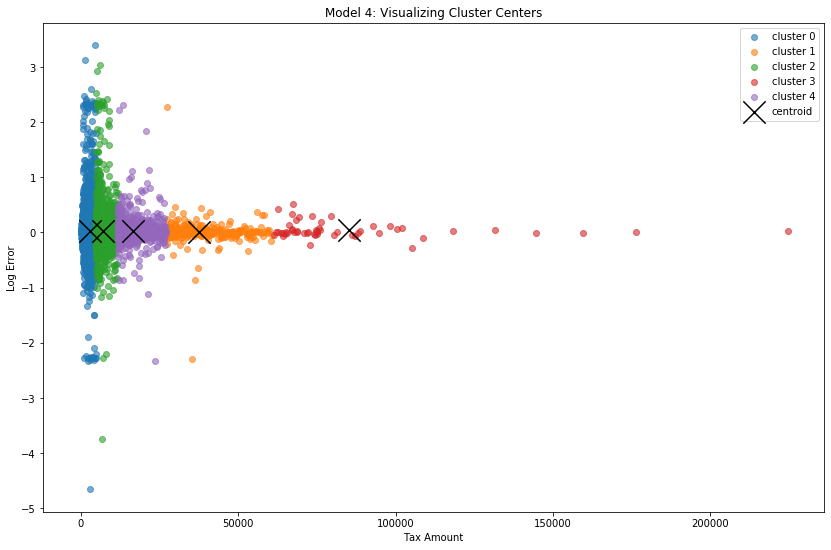

In [38]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

df['cluster'] = kmeans.predict(X)
kmeans.cluster_centers_
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
df.groupby('cluster')['taxamount', 'logerror'].mean()

plt.figure(figsize=(14, 9))

for cluster, subset in df.groupby('cluster'):
    plt.scatter(subset.taxamount, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(x='taxamount', y='logerror', c='black', marker='x', s=500, ax=plt.gca(), label='centroid')

plt.legend()
plt.ylabel('Log Error')
plt.xlabel('Tax Amount')
plt.title('Model 4: Visualizing Cluster Centers')

In [39]:
# Elbow Method

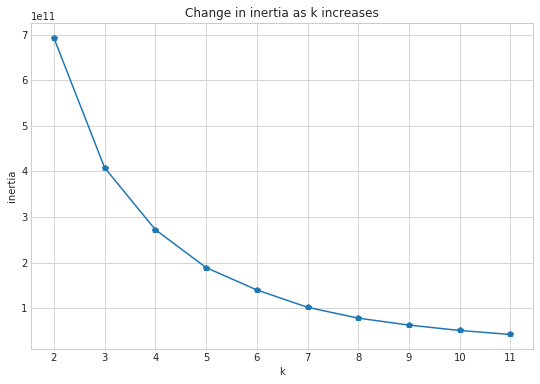

In [40]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='p')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

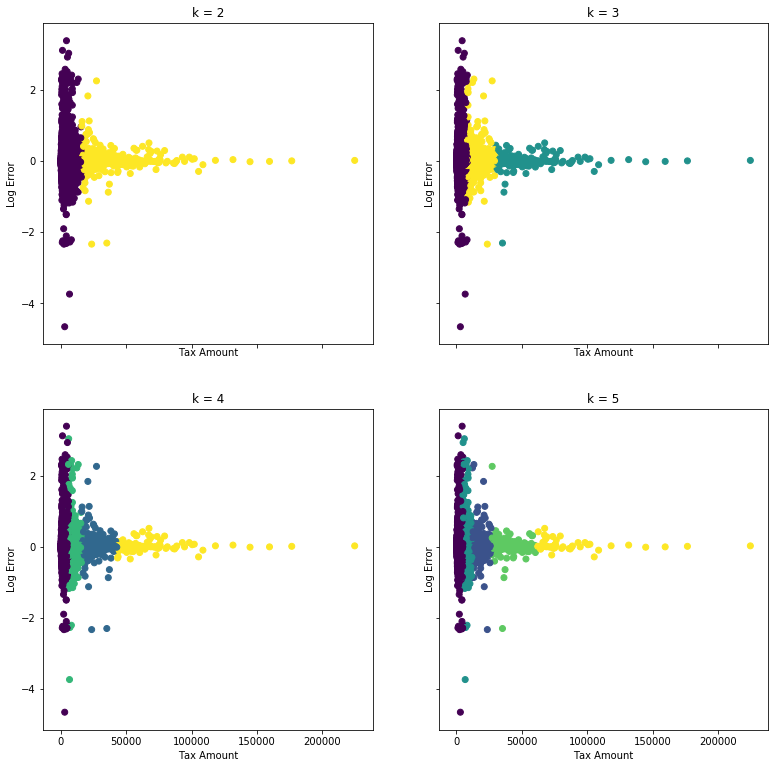

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.taxamount, X.logerror, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='Tax Amount', ylabel='Log Error')

## 5. Conclusions

- Based on elbow method, should cluster=4